# 🐫 **CAMEL Agent to MCP Server Conversion via .to_mcp() for FAISS RAG**


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>

## Overview
This cookbook demonstrates how to convert a CAMEL RAG agent into an MCP server using the .to_mcp() method, allowing other MCP clients to use your agent as a tool.
## What You'll Learn
- How to create a self-contained RAG agent with embedded FAISS tools
- How to convert any CAMEL agent to an MCP server using `.to_mcp()`
- How to test the converted MCP server with a client


## 🎯 Key Concept: The .to_mcp() Method
The `.to_mcp()` method converts any CAMEL agent into an MCP server, making it available as a tool for other MCP clients.






In [ ]:
# Simple example from CAMEL documentation
from camel.agents import ChatAgent

agent = ChatAgent(model="gpt-4o-mini")
mcp_server = agent.to_mcp(name="demo", description="A demo agent")
mcp_server.run(transport="stdio")

# File 1: RAG Agent Configuration (faiss_rag_agent_config.py)

## Purpose: This file creates a self-contained RAG agent with embedded FAISS vector search tools.

## What it does:

Defines three core FAISS tools: create_faiss_index, query_faiss, and get_index_stats

- Implements simple text chunking and vector embeddings using numpy
- Creates a ChatAgent with Gemini model and embedded tools
- Provides a complete RAG system without external dependencies
- Self-contained: No external MCP server dependencies
- FAISS integration: Uses Facebook AI Similarity Search for vector operations
- Simple embeddings: Uses deterministic random embeddings for demonstration
- Tool composition: Wraps functions as FunctionTool objects for CAMEL


In [ ]:
import logging
import os
from pathlib import Path
from typing import List, Dict, Any
import json

from camel.agents import ChatAgent
from camel.messages import BaseMessage
from camel.models import ModelFactory
from camel.types import ModelPlatformType, RoleType
from camel.toolkits import FunctionTool
from camel.storages import FaissStorage
from camel.storages.vectordb_storages.base import VectorRecord, VectorDBQuery
from camel.types.enums import VectorDistance
import numpy as np

# Prevent logging since MCP needs to use stdout
root_logger = logging.getLogger()
root_logger.handlers = []
root_logger.addHandler(logging.NullHandler())

# Global storage instance
faiss_storage = None

def initialize_faiss_storage():
    """Initialize CAMEL's FaissStorage with professional settings"""
    global faiss_storage

    storage_path = Path.cwd() / "rag_storage"
    storage_path.mkdir(exist_ok=True)

    faiss_storage = FaissStorage(
        vector_dim=1536,  # OpenAI embedding dimension
        index_type='HNSW',  # Fast with high recall
        collection_name='rag_documents',
        storage_path=str(storage_path),
        distance=VectorDistance.COSINE,
        m=16,  # HNSW connections per node
    )

    # Load existing index if available
    try:
        faiss_storage.load()
    except:
        pass  # No existing index to load

    return faiss_storage


def create_rag_agent():
    """Create a self-contained RAG agent with CAMEL's FaissStorage"""

    # Initialize storage
    initialize_faiss_storage()

    # Create Gemini model
    model = ModelFactory.create(
        model_platform=ModelPlatformType.GEMINI,
        model_type="gemini-2.5-flash-preview-04-17",
        api_key=os.getenv("GOOGLE_API_KEY"),
        model_config_dict={
            "temperature": 0.2,
        }
    )

    # No tools needed since .to_mcp() doesn't expose them
    tools = []

    print(f"DEBUG: Created {len(tools)} tools:")
    for i, tool in enumerate(tools):
        print(f"  Tool {i+1}: {tool.func.__name__}")

    # Enhanced system message that tells the agent it HAS these tools
    system_content = (
        "You are a professional RAG assistant with access to CAMEL's FaissStorage for vector database operations. "
        "You have the following tools available:\n"
        "1. create_faiss_index(documents, chunk_size) - Create a persistent FAISS index\n"
        "2. query_faiss(query, top_k) - Search for semantically similar content\n"
        "3. get_index_stats() - Get detailed statistics about the vector storage\n"
        "\nYou MUST use these tools when users ask you to create indexes or search for information. "
        "Do not claim you cannot perform these operations - you have the tools to do them!"
    )

    system_message = BaseMessage(
        role_name="Professional RAG Assistant",
        role_type=RoleType.ASSISTANT,
        meta_dict={"task": "Production FAISS RAG Operations"},
        content=system_content
    )

    # Create the agent (conversational interface only)
    rag_agent = ChatAgent(
        system_message=system_message,
        model=model,
        tools=tools  # This should attach the tools
    )

    # Verify tools are attached - Fixed debug code
    print(f"DEBUG: Agent created")
    if hasattr(rag_agent, '_internal_tools'):
        print(f"DEBUG: Agent has {len(rag_agent._internal_tools)} internal tools")
        # Fix: _internal_tools contains tool names (strings), not objects
        for i, tool_name in enumerate(rag_agent._internal_tools):
            print(f"  Internal Tool {i+1}: {tool_name}")
    else:
        print("DEBUG: Agent has no _internal_tools attribute")

    if hasattr(rag_agent, 'tool_dict'):
        print(f"DEBUG: Agent tool_dict: {list(rag_agent.tool_dict.keys())}")
        # Also show the actual tool objects
        for tool_name, tool_obj in rag_agent.tool_dict.items():
            print(f"  {tool_name}: {tool_obj.func.__name__}")

    return rag_agent



# File 2: MCP Server Conversion (faiss_rag_agent_mcp_server.py)
## Purpose: This is the main file that demonstrates the agent-to-MCP conversion.

## What it does:
- Imports the RAG agent from the configuration file
- Uses the .to_mcp() method to convert the agent into an MCP server
- Runs the server with stdio transport for local communication

## Critical Points:
- Must be synchronous (no async/await) - let .to_mcp() handle event loops
- Requires GOOGLE_API_KEY environment variable


In [ ]:
import os
import json
import numpy as np
from typing import List
from pathlib import Path

from faiss_rag_agent_config import (
    create_rag_agent,
    initialize_faiss_storage,
    faiss_storage  # Import the global storage
)
from camel.storages.vectordb_storages.base import VectorRecord, VectorDBQuery

def main():
    """Initialize and run the RAG agent as an MCP server with hybrid approach"""

    # Ensure API key is set
    if not os.getenv("GOOGLE_API_KEY"):
        print("Error: GOOGLE_API_KEY environment variable not set")
        return

    print("DEBUG: Creating RAG agent...")
    # Create the self-contained RAG agent
    rag_agent = create_rag_agent()

    # Ensure storage is initialized at the module level
    print("DEBUG: Ensuring FAISS storage is initialized...")
    storage_instance = initialize_faiss_storage()

    print("DEBUG: Converting agent to MCP server...")

    try:
        # Step 1: Convert ChatAgent to MCP server (for conversational capabilities)
        mcp_server = rag_agent.to_mcp(
            name="RAG-Agent-MCP",
            description="A self-contained RAG assistant with FAISS vector search capabilities"
        )
        print("DEBUG: .to_mcp() conversion successful!")

        # Step 2: Add custom FAISS tools to the same MCP server instance
        print("DEBUG: Adding custom FAISS tools to MCP server...")

        @mcp_server.tool()
        async def create_faiss_index(documents: List[str], chunk_size: int = 1000) -> str:
            """Create a FAISS index from document texts using CAMEL's storage."""
            # Import here to ensure we get the latest global state
            from faiss_rag_agent_config import faiss_storage, initialize_faiss_storage

            try:
                print(f"DEBUG: create_faiss_index called with {len(documents)} documents")

                # Ensure storage is available
                current_storage = faiss_storage
                if current_storage is None:
                    print("DEBUG: Storage is None, initializing...")
                    current_storage = initialize_faiss_storage()

                print(f"DEBUG: Storage status before clear: {current_storage.status().vector_count} vectors")
                current_storage.clear()
                print("DEBUG: Storage cleared successfully")

                all_records = []
                chunk_id = 0

                for doc_idx, doc_text in enumerate(documents):
                    words = doc_text.split()

                    for i in range(0, len(words), max(1, chunk_size // 10)):
                        chunk_words = words[i:i + max(1, chunk_size // 10)]
                        chunk_text = ' '.join(chunk_words)

                        if chunk_text.strip():
                            # Create simple embedding
                            np.random.seed(hash(chunk_text) % (2**32))
                            embedding = np.random.normal(0, 1, 1536).astype(np.float32)

                            record = VectorRecord(
                                id=f"chunk_{chunk_id}",
                                vector=embedding,
                                payload={
                                    "text": chunk_text,
                                    "source_id": doc_idx,
                                    "chunk_id": chunk_id,
                                    "metadata": {
                                        "document_index": doc_idx,
                                        "chunk_index": chunk_id
                                    }
                                }
                            )

                            all_records.append(record)
                            chunk_id += 1

                if all_records:
                    print(f"DEBUG: Adding {len(all_records)} records to storage")
                    current_storage.add(all_records)

                    # Verify the addition
                    final_status = current_storage.status()
                    print(f"DEBUG: Final storage status: {final_status.vector_count} vectors")

                    return json.dumps({
                        "status": "success",
                        "message": f"Indexed {len(all_records)} chunks from {len(documents)} documents",
                        "total_chunks": len(all_records),
                        "final_vector_count": final_status.vector_count
                    })
                else:
                    return json.dumps({"error": "No text chunks were created"})

            except Exception as e:
                import traceback
                error_details = traceback.format_exc()
                print(f"DEBUG: Error in create_faiss_index: {error_details}")
                return json.dumps({"error": f"Error creating FAISS index: {str(e)}", "details": error_details})

        @mcp_server.tool()
        async def query_faiss(query: str, top_k: int = 3) -> str:
            """Query the FAISS index using CAMEL's storage."""
            # Import here to ensure we get the latest global state
            from faiss_rag_agent_config import faiss_storage, initialize_faiss_storage

            try:
                print(f"DEBUG: query_faiss called with query: '{query}', top_k: {top_k}")

                # Ensure storage is available
                current_storage = faiss_storage
                if current_storage is None:
                    print("DEBUG: Storage is None, initializing...")
                    current_storage = initialize_faiss_storage()

                status = current_storage.status()
                print(f"DEBUG: Storage has {status.vector_count} vectors")

                if status.vector_count == 0:
                    return json.dumps({"error": "No documents have been indexed yet"})

                # Create query embedding
                np.random.seed(hash(query) % (2**32))
                query_embedding = np.random.normal(0, 1, 1536).astype(np.float32)

                db_query = VectorDBQuery(
                    query_vector=query_embedding,
                    top_k=min(top_k, status.vector_count)
                )

                results = current_storage.query(db_query)

                formatted_results = []
                for result in results:
                    formatted_results.append({
                        "id": result.record.id,
                        "text": result.record.payload.get("text", ""),
                        "metadata": result.record.payload.get("metadata", {}),
                        "score": float(result.similarity)
                    })

                return json.dumps({
                    "results": formatted_results,
                    "query_info": {
                        "total_results": len(formatted_results),
                        "search_type": "semantic_similarity"
                    }
                })

            except Exception as e:
                import traceback
                error_details = traceback.format_exc()
                print(f"DEBUG: Error in query_faiss: {error_details}")
                return json.dumps({"error": f"Error querying FAISS index: {str(e)}", "details": error_details})

        @mcp_server.tool()
        async def get_index_stats() -> str:
            """Get statistics about the FAISS storage."""
            # Import here to ensure we get the latest global state
            from faiss_rag_agent_config import faiss_storage, initialize_faiss_storage

            try:
                print("DEBUG: get_index_stats called")

                # Ensure storage is available
                current_storage = faiss_storage
                if current_storage is None:
                    print("DEBUG: Storage is None, initializing...")
                    current_storage = initialize_faiss_storage()

                status = current_storage.status()

                stats = {
                    "vector_count": status.vector_count,
                    "vector_dimension": 1536,
                    "index_type": "HNSW",
                    "distance_metric": "cosine",
                    "collection_name": current_storage.collection_name,
                    "persistent_storage": current_storage.storage_path is not None,
                    "storage_path": str(current_storage.storage_path) if current_storage.storage_path else "in-memory"
                }

                return json.dumps(stats, indent=2)

            except Exception as e:
                import traceback
                error_details = traceback.format_exc()
                print(f"DEBUG: Error in get_index_stats: {error_details}")
                return json.dumps({"error": f"Error getting index stats: {str(e)}", "details": error_details})

        print("DEBUG: Custom FAISS tools added successfully!")
        print("DEBUG: Starting hybrid MCP server...")

        # Run the MCP server with both conversational and tool capabilities
        mcp_server.run(transport="stdio")

    except Exception as e:
        import traceback
        error_details = traceback.format_exc()
        print(f"DEBUG: Hybrid MCP setup failed: {e}")
        print(f"DEBUG: Error details: {error_details}")
        return

if __name__ == "__main__":
    main()

# File 3: Test Client (test_faiss_rag_mcp_client.py)
## Purpose: Tests the converted MCP server by connecting to it as a client.

## What it does:

- Creates an MCP configuration that points to your server script
- Connects to the MCP server using MCPToolkit
- Creates a client agent that can use the server's tools
- Provides an interactive interface to test RAG functionality



In [ ]:
import asyncio
import json
import os
import sys
from getpass import getpass
from pathlib import Path

from camel.agents import ChatAgent
from camel.logger import get_logger
from camel.messages import BaseMessage
from camel.models import ModelFactory
from camel.toolkits import MCPToolkit
from camel.types import ModelPlatformType, RoleType

logger = get_logger(__name__)

async def main():
    """Test the self-contained RAG MCP server"""

    # Configuration for connecting to our RAG MCP server
    rag_mcp_config = {
        "mcpServers": {
            "rag_agent_server": {
                "type": "script",
                "command": "python",
                "args": ["faiss_rag_agent_mcp_server.py"],
                "transport": "stdio",
                "env": {
                    "GOOGLE_API_KEY": os.getenv("GOOGLE_API_KEY") or getpass('Enter Gemini API key for server: ')
                }
            }
        }
    }

    # Write config file
    config_path = Path.cwd() / "rag_mcp_client_config.json"
    with open(config_path, 'w') as f:
        json.dump(rag_mcp_config, f, indent=2)

    # Get API key for client model
    # gemini_api_key = getpass('Enter your Gemini API key for client: ')
    # if not gemini_api_key:
        # logger.error("API key is required to proceed.")
        # return
    # os.environ["GOOGLE_API_KEY"] = gemini_api_key
    gemini_api_key = os.getenv("GOOGLE_API_KEY") or getpass('Enter Gemini API key for client: ')

    # Connect to the RAG MCP server
    logger.info("Connecting to self-contained RAG MCP server...")
    mcp_toolkit = MCPToolkit(config_path=str(config_path))

    await mcp_toolkit.connect()
    tools = mcp_toolkit.get_tools()

    # Debugging:-------------------
    # Add debug before the existing debug section:
    print(f"\n=== DEBUG: MCP Client received {len(tools)} tools ===")
    if tools:
        for i, tool in enumerate(tools):
            print(f"Tool {i+1}:")
            print(f"  Name: {getattr(tool, 'name', 'Unknown')}")
            if hasattr(tool, 'func'):
                print(f"  Function: {tool.func.__name__}")
                print(f"  Doc: {tool.func.__doc__[:100] if tool.func.__doc__ else 'No doc'}...")
            else:
                print(f"  Type: {type(tool)}")
                print(f"  Attributes: {[attr for attr in dir(tool) if not attr.startswith('_')]}")
    else:
        print("  No tools received from MCP server!")
    print("=" * 50)
    # Debugging--------------------

    if not tools:
        logger.error("No tools found from the RAG MCP server")
        return

    logger.info(f"Found {len(tools)} tools from RAG MCP server")

    try:
        # Create a client model to interact with the RAG MCP server
        model = ModelFactory.create(
            model_platform=ModelPlatformType.GEMINI,
            model_type="gemini-2.5-flash-preview-04-17",
            api_key=gemini_api_key,
            model_config_dict={
                "temperature": 0.2,
                # "max_output_tokens": 1024,
            }
        )

        system_message = BaseMessage(
            role_name="RAG Client",
            role_type=RoleType.ASSISTANT,
            meta_dict={"task": "RAG MCP Client"},
            content="You are a client that uses a self-contained RAG MCP server for document search and retrieval tasks."
        )

        # Create client agent with RAG MCP tools
        client_agent = ChatAgent(
            system_message=system_message,
            model=model,
            tools=tools
        )
        client_agent.reset()

        # Debugging --------------------------

        # Add direct tool testing:
        print("\n=== DEBUG: Testing direct tool access ===")
        if tools:
            try:
                # Try to call get_index_stats directly
                stats_tool = None
                for tool in tools:
                    if hasattr(tool, 'func') and 'stats' in tool.func.__name__:
                        stats_tool = tool
                        break

                if stats_tool:
                    print("Found stats tool, testing direct call...")
                    result = stats_tool.func()
                    print(f"Direct tool call result: {result}")
                else:
                    print("Could not find stats tool")
            except Exception as e:
                print(f"Direct tool call failed: {e}")
        else:
            print("No tools to test directly")
        print("=" * 50)
# DEBUGGING ----------------------------------

        print("\n=== Self-Contained RAG Agent as MCP Server Test ===\n")
        print("Testing CAMEL RAG agent (with embedded FAISS) exported as MCP server using .to_mcp()...")
        print("Type 'exit' to quit\n")

        # Test the RAG MCP server
        test_message = "Hello! Please create an index with documents about AI, machine learning, and FAISS, then search for information about vector databases."
        print(f"Test Query: {test_message}\n")

        response = await client_agent.astep(test_message)
        if response and response.msgs:
            print(f"RAG MCP Response: {response.msgs[0].content}\n")

        # Interactive loop
        while True:
            user_input = input("You: ")
            if user_input.lower() == 'exit':
                break

            response = await client_agent.astep(user_input)

            if response and response.msgs:
                agent_reply = response.msgs[0].content
                print(f"RAG MCP Agent: {agent_reply}\n")
            else:
                print("No response received.\n")

    except Exception as e:
        logger.error(f"An error occurred: {str(e)}")
        print(f"\nError: {str(e)}")
    finally:
        try:
            await mcp_toolkit.disconnect()
        except Exception as cleanup_error:
            logger.warning(f"Error during cleanup: {cleanup_error}")

if __name__ == "__main__":
    if sys.platform == "win32" and sys.version_info >= (3, 8):
        asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
    asyncio.run(main())

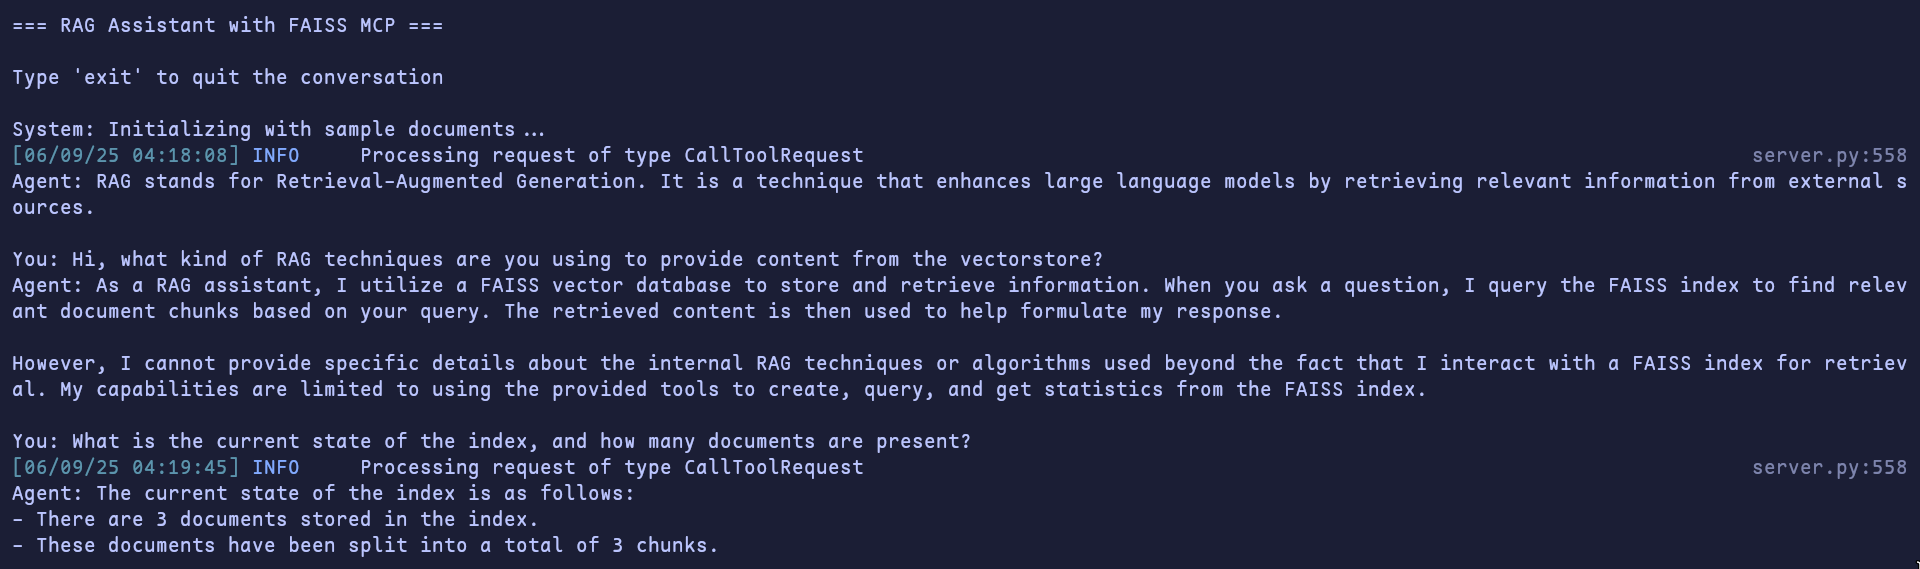

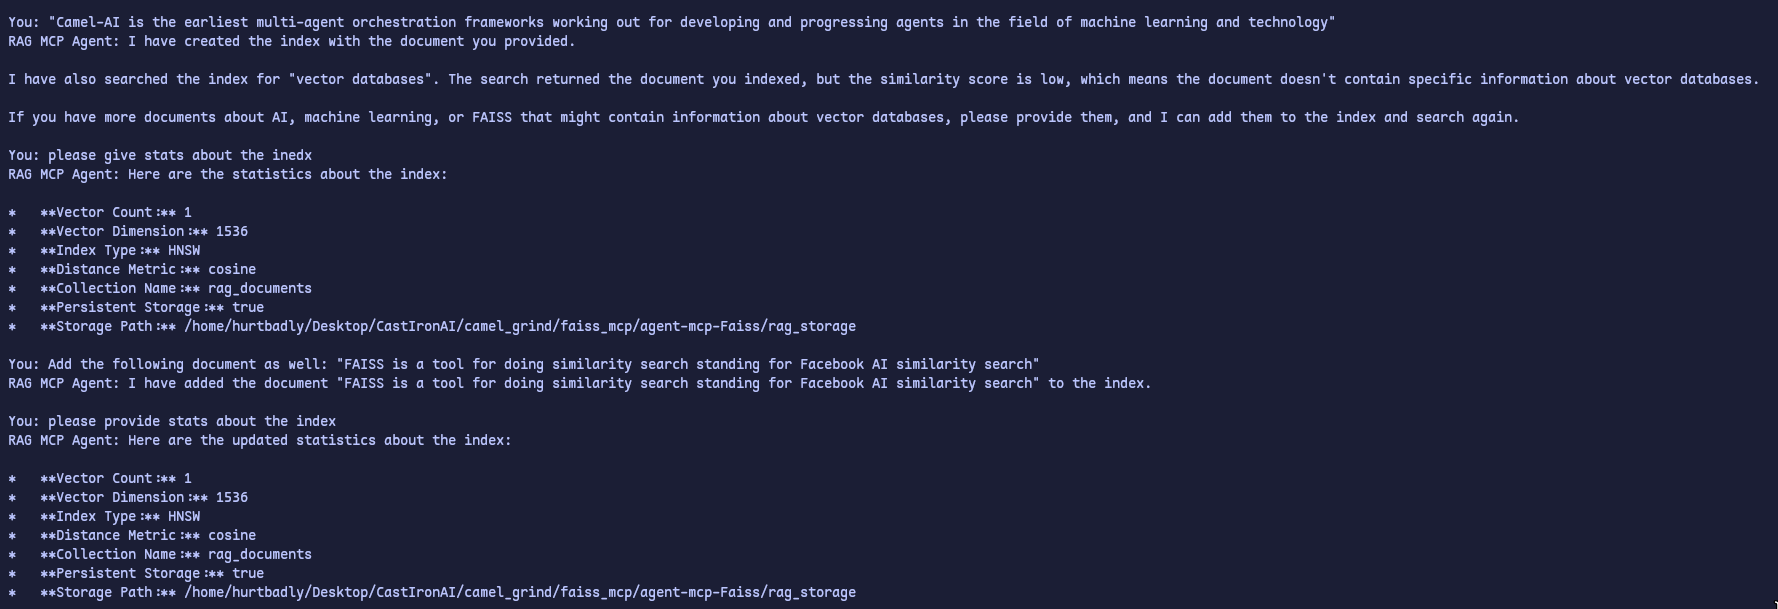

# Running the Example
## Step 1: Set Up Environment
```python
export GOOGLE_API_KEY="your-gemini-api-key-here"
```
## Step 2: Test the MCP Server (Optional)
This starts the server and waits for connections. If it runs without errors, the conversion worked!
```python
python faiss_rag_agent_mcp_server.py
```
## Step 3: Run the Client Test
```python
python test_faiss_rag_mcp_client.py
```


## Key Takeaways

### ✅ What We Accomplished

1. **Self-Contained Agent**: Created a RAG agent with embedded FAISS tools
2. **Agent → MCP Conversion**: Used `.to_mcp()` to convert the agent to an MCP server
3. **Cross-Client Compatibility**: The MCP server works with any MCP client
4. **Tool Composition**: Other agents can now use our RAG capabilities as tools


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>